<h1 align='center'> Machine learning against pollution: clustering analysis of Greater Mexico City's air quality </h1>

In this notebook, we will inspect the possible relationships between air quality and the types and amounts of venues in a 2km radius around air quality measuring stations, across Greater Mexico City (GMX).

<hr>
<h1 align='center'> 0. Loading libraries </h1>
<hr>

In [1]:
import sys

!pip install lxml
!pip install cssselect
!pip install folium
%matplotlib inline

import requests, json, folium, random
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from pandas.io.json import json_normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lxml.html import parse
import lxml.html as lh
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

  Using cached https://files.pythonhosted.org/packages/dd/ba/a0e6866057fc0bbd17192925c1d63a3b85cf522965de9bc02364d08e5b84/lxml-4.5.0-cp36-cp36m-manylinux1_x86_64.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/lxml-4.5.0.dist-info'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/3b/d4/3b5c17f00cce85b9a1e6f91096e1cc8e8ede2e1be8e96b87ce1ed09e92c5/cssselect-1.1.0-py2.py3-none-any.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/cssselect-1.1.0.dist-info'
Consider using the `--user` option or check the permissions.

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via t

ModuleNotFoundError: No module named 'folium'

<hr>
<h1 align='center'> 1. Preparing air quality data </h1>
<hr>

The air quality data is split into six files: one for carbon monoxide (CO), nitrogen dioxide (NO2), ozone (O3), sulfur dioxide (SO2), particulate matter less than 10 micrometers in diameter (PM10) and particulate matter less than 2.5 micrometers in diameter (PM25).

Let's read the data files and see their contents:

In [6]:
molecules = ['CO', 'NO2', 'O3', 'SO2', 'PM10', 'PM25'] 
dfs = np.zeros(len(molecules), dtype = object) # creating an array for dataframes
 
for i, molecule in enumerate(molecules):
    dfs[i] = pd.read_csv(molecule + '.csv', delimiter=',')

This is what the NO2 file looks like:

In [7]:
dfs[1].head()

,FECHA,HORA,ACO,AJM,ATI,BJU,CAM,CCA,CHO,COY,...,SAG,SFE,SJA,TAH,TLA,TLI,UAX,UIZ,VIF,XAL
0,2019-01-01,1,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
1,2019-01-01,2,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,2019-01-01,3,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
3,2019-01-01,4,-99,1,15,15,17,15,13,-99,...,15,7,-99,11,14,-99,14,16,18,17
4,2019-01-01,5,-99,1,12,15,16,13,12,-99,...,14,6,-99,7,14,-99,14,16,16,16


The fist and second columns are the date and hour in which measurements were taken. The next columns correspond to the codenames of the stations. We will see more of these codes in section 2, when we prepare the venue data. Let's see in which months pollution is highest, so that we can choose an appropriate range of time to analyze:

In [8]:
for df, mol in zip(dfs, molecules):
    proxy = df.drop(columns = ['FECHA', 'HORA'])
    max_pollution = proxy.values.max()
    max_pol_col = proxy.max().idxmax()
    max_pol_row = proxy[max_pol_col].idxmax()
    
    print(mol, '-->', max_pol_col, df.loc[max_pol_row, 'FECHA'], max_pollution)

CO --> TLA 2019-02-15 25
NO2 --> CAM 2019-01-07 52
O3 --> CAM 2019-03-30 155
SO2 --> TLI 2019-12-19 68
PM10 --> VIF 2019-01-01 166
PM25 --> NEZ 2019-01-01 185


From last year, the winter months (plus march) were the most polluted. We will take the data from january to march of 2019, and december of 2019.

In [9]:
def format_dataframe(df):
    
    df = df.loc[df['FECHA'].str.contains('-01-') | df['FECHA'].str.contains('-02-') | 
           df['FECHA'].str.contains('-03-') | df['FECHA'].str.contains('-12-')].copy()
    df = df.drop(columns = ['FECHA', 'HORA'])
    
    for col in df.columns[2:]:
        df.loc[:, col] = pd.to_numeric(df[col], errors = 'coerce')

    return df.copy()

In [10]:
for i, frame in enumerate(dfs):
    dfs[i] = format_dataframe(frame)

In [11]:
dfs[1].head()

,ACO,AJM,ATI,BJU,CAM,CCA,CHO,COY,CUA,CUT,...,SAG,SFE,SJA,TAH,TLA,TLI,UAX,UIZ,VIF,XAL
0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
1,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
3,-99,1,15,15,17,15,13,-99,14,9,...,15,7,-99,11,14,-99,14,16,18,17
4,-99,1,12,15,16,13,12,-99,16,8,...,14,6,-99,7,14,-99,14,16,16,16


Now we see some columns with -99, such as "ACO", "AJM", etc. This is the case for every dataframe. We should maybe get rid of those columns, but first, we should count the proportion of -99 values per column. We're going to save any column with at least 66% of useful data.

In [12]:
def filter_empty(df):
    length = df.shape[0]
    valid_columns = []

    for col in df.columns.values:
        series = df[col] == -99
        counts = series.value_counts()
        ratio = (counts.values * np.array(counts.index).astype(int)).sum()/length
        if ratio < 0.34:
            valid_columns.append(col) # getting the names of columns with >66% fullness

    return df[valid_columns].copy()

In [13]:
for i, frame in enumerate(dfs):
    dfs[i] = filter_empty(frame)

In [14]:
max_stations = 0
for frame in dfs:
    cols = frame.shape[1]
    if cols > max_stations:
        max_stations = cols
        stations_set = frame.columns.values

We will now take a big leap: averaging every column, for each dataframe, separately. This will give us a yearly average of each molecule, at each station. The averages will be stored in a new dataframe, along their respective stations.

In [15]:
cd = np.zeros((max_stations, len(molecules))) 

for j, molecule in enumerate(molecules): #for each molecule
    current = dfs[j]
    for i, col in enumerate(stations_set):
        if col in current.columns:       #check if columns from the big set are in subset
            cd[i, j] = current.loc[:, col].replace(-99, np.nan).mean()
    
cd = pd.DataFrame(data = cd)
cd.columns = molecules
cd.index = stations_set

cd = cd.replace(0, np.nan)
stations_set = frame.columns.values

print(cd.shape)
cd.head()

(26, 6)


,CO,NO2,O3,SO2,PM10,PM25
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,NaN
BJU,4.624619,NaN,21.430937,NaN,NaN,NaN
CCA,3.840015,11.999284,22.680272,4.214862,NaN,63.772226
CHO,4.696246,9.789322,18.401833,1.866947,NaN,NaN


Our data doesn't look that promising. There are a lot of stations that haven't been doing their job, and thus, there were many empty rows, and we still have missing data. To mitigate some of this, let's fill the NaNs with the mean of their respective columns, and add some noise so the clustering algorithm doesn't group those stations together instantly.

In [16]:
for i, col in enumerate(molecules):
    column_data = cd[col]
    mean = column_data.mean()
    maxi = column_data.max()
    for j, row in enumerate(cd.index.values):
        if np.isnan(cd.loc[row, col]):
            random.seed(j)
            noise = random.uniform(-1.0, 1.0) * random.uniform(0.0, maxi - mean)
            cd.loc[row, col] = mean + noise

cd.head()

,CO,NO2,O3,SO2,PM10,PM25
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,62.950649
BJU,4.624619,16.542634,21.430937,10.964558,96.108170,79.460323
CCA,3.840015,11.999284,22.680272,4.214862,57.399327,63.772226
CHO,4.696246,9.789322,18.401833,1.866947,65.168476,69.238241


## Exploratory analysis of the data

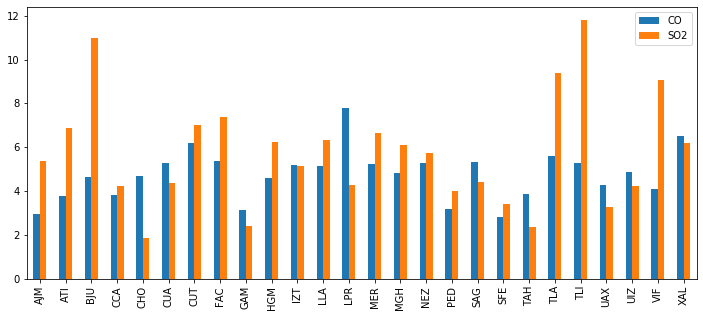

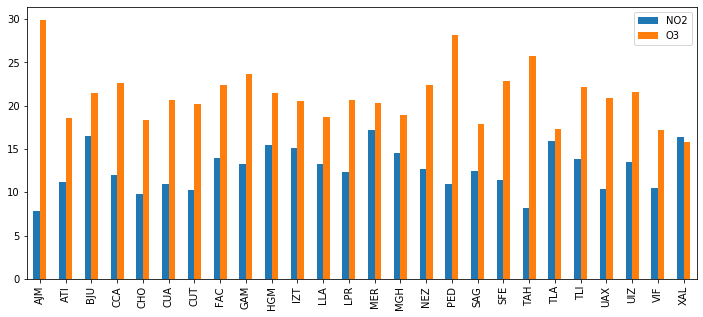

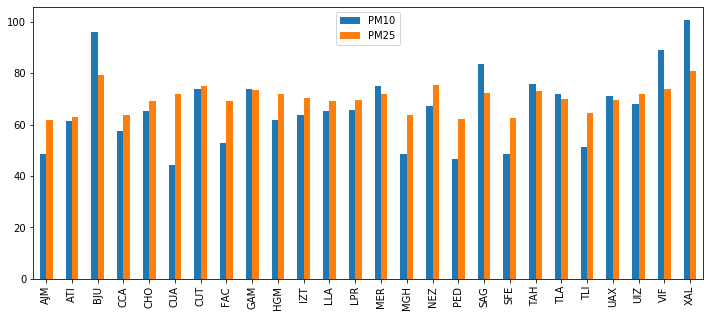

In [17]:
cd.plot(y = [molecules[0], molecules[3]], kind='bar', figsize=(12,5))
cd.plot(y = [molecules[1], molecules[2]], kind='bar', figsize=(12,5))
cd.plot(y = [molecules[4], molecules[5]], kind='bar', figsize=(12,5))

We haven't normalized yet, but we will, once the dataset is complete. As things are, most of our data is in inconsistent units (some in parts per million (ppm), some in parts per billion (ppb) and others in micrograms per cubic meter (ug/m^3).

<hr>
<h1 align='center'> 2. Preparing Venue data </h1>
<hr>

We will now obtain the coordinates for each station from the Dirección de Monitoreo Atmosférico (Athmospheric Monitoring Direction, url: http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==)

In [18]:
def scrape_table(url, length, level):
    req = requests.get(url)
    doc = lh.fromstring(req.content)
    tr_elements = doc.xpath('//tr')
    col=[] # Create empty list
    
    for t in tr_elements[level]:  # create header of the table
        name = t.text_content()
        col.append((name.replace("\n",""),[]))
        
    for j in range(level + 1,len(tr_elements)): # populate the table
        raw_row = tr_elements[j]
        row = [clean_string(word.text_content()) for word in raw_row.iterchildren()] # get words in each column
        
        if len(row)!= length: # if the row doesn't have "length" columns, then it isn't part of our table
            break
            
        for i, data in enumerate(row):
            col[i][1].append(data)

    Dict={title:column for (title,column) in col}
    return pd.DataFrame(Dict)

In [19]:
def clean_string(string):
    return string.replace('\t', '').replace('\n', '').replace('\r', '').replace("msnm", '')

Inspecting the url, we see that there is only one table. The column 'Clave' contains short names for the stations, 'Nombre' contains the actual names of the stations, 'Alcaldia o municipio' is where the stations are located, and 'Entidad' is either Mexico City or Estado de Mexico, which is the area around Mexico City. 

In [20]:
deleg = scrape_table('http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==', 4, 0)
deleg.head()

,Clave,Nombre,Alcaldía o municipio,Entidad
0,ACO,Acolman,Acolman,Estado de México
1,AJU,Ajusco,Tlalpan,CDMX
2,AJM,Ajusco Medio,Tlalpan,CDMX
3,ATI,Atizapán,Atizapán de Zaragoza,Estado de México
4,BJU,Benito Juarez,Benito Juárez,CDMX


We then get the data from the links inside the table above. This will give us the coordinates of each station:

In [21]:
dom = parse('http://www.aire.cdmx.gob.mx/default.php?opc=%27ZaBhnmI=&dc=%27ZA==').getroot()
links = dom.cssselect('a')

latlon = []

for link in links:
    if len(link.text_content()) == 3:
        latlon.append(scrape_table(link.get('href'), 6, 2))

ll = latlon[0]

for i in range(1, len(latlon)):
    ll = ll.append(latlon[i], ignore_index=True)

ll.head()

,Domicilio,Alcaldía o municipio,Estado,Latitud,Longitud,Altitud
0,"Calzada de los Agustinos s/n, Col. Centro, C.P...",Acolman,Estado de México,19.635501,-98.912003,2198
1,"Km 36.5 Carretera Federal México-Cuernavaca, C...",Tlalpan,CDMX,19.154674,-99.162459,2953
2,"Encinos # 41, col. Miguel Hidalgo 4ta sección,...",Tlalpan,CDMX,19.272100,-99.207658,2619
3,"Oceano Pacífico s/n, Col. Lomas Lindas, C.P. 5...",Atizapán de Zaragoza,Estado de México,19.576963,-99.254133,2341
4,"Municipio libre y Uxmal, Col. Santa Cruz Atoya...",Benito Juárez,CDMX,19.371612,-99.158969,2250


From the dataframes, we only need 'Clave', 'Latitud', 'Longitud' and 'Altitud'. Let's drop every other column, join the dataframes, make 'Clave' the index, rename the columns and drop every station without air quality data:

In [22]:
if 'Clave' in deleg.columns:
    deleg = deleg[['Clave']].join(ll[['Latitud', 'Longitud', 'Altitud']])
    deleg.index = deleg['Clave']
    deleg.drop(columns = ['Clave'], inplace= True)

deleg.index.name = None
deleg.rename(columns = {'Latitud': 'Latitude', 'Longitud': 'Longitude', 'Altitud': 'Altitude'}, inplace = True)
deleg.loc['FAR', 'Latitude'] = 19.473692

for col in deleg.columns:
    deleg.loc[:, col] = pd.to_numeric(deleg[col], errors = 'coerce')
    
deleg = deleg.loc[cd.index.values].copy()
    
deleg.head()

,Latitude,Longitude,Altitude
AJM,19.272100,-99.207658,2619
ATI,19.576963,-99.254133,2341
BJU,19.371612,-99.158969,2250
CCA,19.326200,-99.176100,2280
CHO,19.266948,-98.886088,2253


We see that our coordinates dataframe has the same stations as our air quality dataframe. Let's visualize these stations.

In [23]:
# create map of Mexico City (and Estado de Mexico) using latitude and longitude values
latitude = 19.4284700
longitude = -99.1276600

map_mx = folium.Map(location=[latitude, longitude], zoom_start = 10)
    
# add markers to map
for lat, lng, label in zip(deleg['Latitude'], deleg['Longitude'], deleg.index):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(map_mx)  

map_mx

Now we can set up our credentials for the Foursquare API:

In [24]:
CLIENT_ID = 'ALOOBVNM4UKUV3TC31W42DGIRYYUGBX3YL25EIQF5S0XSMFK' # your Foursquare ID
CLIENT_SECRET = 'ZKPJX1KRF0YEEGWHTMLIYBPLJGYPRBE44JBHGSBKL4FRU1XT' # your Foursquare Secret
TOKEN = 'FT0HKS1OFGA4B5N5MZR5C1JE3KSC2XTKOMEVYFZJFWRFJKZN'
VERSION = '20180605' # Foursquare API version

LIMIT = 1000 # limit of number of venues returned by Foursquare API

Define the function to fecth locations near to our stations:

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&oauth_token={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            TOKEN,
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

For good measure, we will grab every venue from a 500 m radius to a 2000 m radius. The 500 m search yields some venues that do not exist in the 2000 m search, maybe due to some restriction in the API. We can then join both dataframes and drop the duplicates, to prevent overlapping. 

In [26]:
venues0 = getNearbyVenues(names = deleg.index,
                         latitudes = deleg['Latitude'],
                         longitudes = deleg['Longitude'],
                         radius = 500)

In [27]:
venues1 = getNearbyVenues(names = deleg.index,
                         latitudes = deleg['Latitude'],
                         longitudes = deleg['Longitude'],
                         radius = 2000)

Let's drop the duplicate venues. We will do this by comparing the venue name along with its latitude and longitude, as there cannot be two different venues with the same name and coordinates.

In [28]:
venues = venues0.append(venues1)
print(venues.shape)
venues = venues.drop_duplicates(subset = ['Venue', 'Venue Latitude', 'Venue Longitude'], keep = False)
venues = venues.reset_index(drop = True)
print(venues.shape)

(2403, 7)
(2135, 7)


Dropping duplicates, we got rid of almost 300 venues; however, we still have more than 2000 venues. If we do one-hot encoding, we will have hundreds of dimensions in our data (one per category), and we don't even have a hundred data samples. If we are to cluster this, we need to group our venues in more general categories, and use those categories as our new dimensions. We will group every place to eat under a 'Restaurants & Bars' label, every shop and store under the 'Stores' label, and so on. Sadly, we will do that manually.

In [29]:
categories = np.unique(venues['Venue Category'])
stations = deleg.index.values

stores = ['Store', 'Shop', 'Auto Dealership', 'Bookstore', 'Bakery', 'Market']
restaurants_bars = ['Restaurant', 'Bar', 'Joint', 'Beer', 'Place', 'Botanero', 
                    'Breakfast Spot', 'Food', 'Brewery', 'Tea', 'Cafeteria', 'Buffet']
medical = ['Dentist', 'Dental', 'Doctor', 'Veterinarian']
buildings = ['Building', 'Office']
hotels_hostels = ['Bed & Breakfast', 'Hostel', 'Motel']
museums_galleries = ['Museum', 'Gallery', 'Exhibit']
plazas = ['Plaza']
farms = ['Farm']
parks_forests = ['Park', 'Forest']
schools = ['University', 'School']
gyms_sports = ['Gym', 'Sports', 'Studio', 'Martial Arts', 'Paintball', 'Go Kart']
stadiums_theaters = ['Stadium', 'Concert Hall', 'Theater']
bus_stations = ['Bus Stop', 'Bus Station']
sports_fields = ['Soccer', 'Golf']
industrial = ['Gas Station', 'Distillery']

venues_list = [stores, restaurants_bars, medical, buildings, hotels_hostels, museums_galleries, plazas, 
         farms, parks_forests, schools, gyms_sports, stadiums_theaters, bus_stations, sports_fields, industrial]
names = ['Stores', 'Restaurants & Bars', 'Medical', 'Buildings & Offices', 'Hotels & Hostels',
        'Museums & Galleries', 'Plazas', 'Farms', 'Parks & Forests', 'Schools', 'Gyms & Sports', 
         'Stadiums & Theaters', 'Bus Stations', 'Sports Fields', 'Industrial']

skull = np.zeros((len(stations) + 1, len(venues_list) + 1), dtype=object)
skull[0, 0] = 'Code'
skull[0, 1:] = names
skull[1:, 0] = stations

for i, station in enumerate(stations):
    venues_in_station = venues[venues['Code'] == station]
    for j, type_of_venue in enumerate(venues_list):
        count = 0
        for k, specific_venue in enumerate(type_of_venue):
            a = venues_in_station[venues_in_station['Venue Category'].str.contains(specific_venue)]
            count += a['Venue Category'].count()
        skull[i + 1, j + 1] = count    

In [30]:
mx = pd.DataFrame(skull[1:, 1:])
mx.index = skull[1:, 0]
mx.columns = skull[0, 1:]
mx.loc['XAL', 'Industrial'] += 1 # accounting for soap factory in XAL, missregistered in foursquare as a lounge

mx.head()

,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,7,28,0,1,0,0,0,0,1,0,4,0,0,0,0
ATI,5,22,0,1,0,0,0,0,2,0,4,0,0,2,0
BJU,48,55,0,3,1,2,0,0,4,0,13,8,0,4,0
CCA,9,59,0,0,0,2,1,0,3,2,9,7,2,1,0
CHO,6,29,0,1,0,0,0,0,0,0,3,0,0,0,0


In [31]:
print(venues.shape)
print(mx.shape)

(2135, 7)
(26, 15)


We've reduced our dimensions from 2000 to 15. Nice! But we can do better.

## Exploratory analysis of the data

Let's do a bar plot to see which group of venue is the most common among all samples:

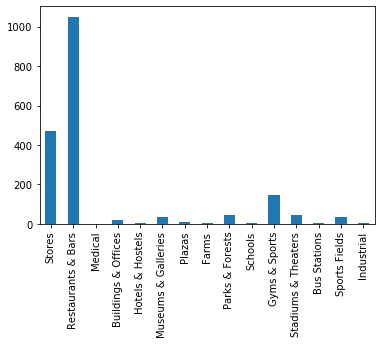

In [32]:
series = mx[names].sum()
series.plot.bar()

As expected, most venues are either places to eat or stores of some kind.

<hr>
<h1 align='center'> 3. Joining the pieces together </h1>
<hr>

Let's add the altitude to this dataframe, mx, and join it with the air quality dataframe, cd:

In [33]:
if not ('Altitude' in mx.columns): 
    mx.insert(0, 'Altitude', deleg['Altitude'])
cdmx = cd.join(mx)
cdmx = cdmx.dropna()
cdmx.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,2.957509,7.826194,29.899060,5.377872,48.423798,61.818256,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,3.788774,11.174881,18.627983,6.873116,61.458678,62.950649,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,4.624619,16.542634,21.430937,10.964558,96.108170,79.460323,2250,48,55,0,...,2,0,0,4,0,13,8,0,4,0
CCA,3.840015,11.999284,22.680272,4.214862,57.399327,63.772226,2280,9,59,0,...,2,1,0,3,2,9,7,2,1,0
CHO,4.696246,9.789322,18.401833,1.866947,65.168476,69.238241,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Let's proceed to calculate the IMECA for each pollutant. First, we have to convert every molecule concentration to ppm (O3, SO2 and NO2 are in ppb units.)

In [34]:
cdmx_ppm = cdmx.copy()
cdmx_ppm['O3'] = cdmx_ppm['O3'].multiply(1./1000)
cdmx_ppm['NO2'] = cdmx_ppm['NO2'].multiply(1./1000)
cdmx_ppm['SO2'] = cdmx_ppm['SO2'].multiply(1./1000)
cdmx_ppm.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,2.957509,0.007826,0.029899,0.005378,48.423798,61.818256,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,3.788774,0.011175,0.018628,0.006873,61.458678,62.950649,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,4.624619,0.016543,0.021431,0.010965,96.108170,79.460323,2250,48,55,0,...,2,0,0,4,0,13,8,0,4,0
CCA,3.840015,0.011999,0.022680,0.004215,57.399327,63.772226,2280,9,59,0,...,2,1,0,3,2,9,7,2,1,0
CHO,4.696246,0.009789,0.018402,0.001867,65.168476,69.238241,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Next, let's calculate the IMECA:

In [35]:
def imeca(df):
    df_ = df.copy()
    
    #for O3
    df_['O3'] = df['O3'].multiply(100./0.11)
    
    #for SO2
    df_['SO2'] = df['SO2'].multiply(100./0.13) 
    
    #for CO
    df_.loc[df['CO'] <= 5.50, ['CO']] = df.loc[df['CO'] <= 5.50, ['CO']] * (50./5.50)
    df_.loc[df['CO'] > 5.50 , ['CO']] = 1.82 + df.loc[df['CO'] > 5.50, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 11.00 , ['CO']] = 2.73+ df.loc[df['CO'] > 11.00, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 16.50 , ['CO']] = 3.64 + df.loc[df['CO'] > 16.50, ['CO']] * (49./5.49)
    df_.loc[df['CO'] > 22.00 , ['CO']] = df.loc[df['CO'] > 22.00, ['CO']] * (201./22.01)
    
    #for NO2
    df_.loc[df['NO2'] <= 0.105, ['NO2']] = df.loc[df['NO2'] <= 0.105, ['NO2']] * (50./0.105)
    df_.loc[df['NO2'] > 0.105, ['NO2']] = 1.058 + df.loc[df['NO2'] > 0.105, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.210, ['NO2']] = 1.587 + df.loc[df['NO2'] > 0.210, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.315, ['NO2']] = 2.115 + df.loc[df['NO2'] < 0.315, ['NO2']] * (49./0.104)
    df_.loc[df['NO2'] > 0.420, ['NO2']] = df.loc[df['NO2'] < 0.420, ['NO2']] * (201./0.421)
    
    #for PM10
    df_.loc[df['PM10'] <= 120.0 , ['PM10']] = df.loc[df['PM10'] <= 120.0, ['PM10']] * (5./6)
    df_.loc[df['PM10'] > 120.0 , ['PM10']] = 40.0 + df.loc[df['PM10'] > 120.0, ['PM10']] * (0.5)
    df_.loc[df['PM10'] > 320.0 , ['PM10']] = df.loc[df['PM10'] > 320.0, ['PM10']] * (5./8)
    
    #for PM25
    df_.loc[df['PM25'] <= 15.4 , ['PM25']] = df.loc[df['PM25'] <= 15.4, ['PM25']] * (50./15.4)
    df_.loc[df['PM25'] > 15.4 , ['PM25']] = 20.5 + df.loc[df['PM25'] > 15.4, ['PM25']] * (49./24.9)
    df_.loc[df['PM25'] > 40.4 , ['PM25']] = 21.3 + df.loc[df['PM25'] > 40.4, ['PM25']] * (49./24.9)
    df_.loc[df['PM25'] > 65.4 , ['PM25']] = 113.2 + df.loc[df['PM25'] > 65.4, ['PM25']] * (49./84.9)
    df_.loc[df['PM25'] > 150.4 , ['PM25']] = df.loc[df['PM25'] > 150.4, ['PM25']] * (201./150.5)
    
    return df_

In [36]:
cdmx_imeca = imeca(cdmx_ppm)
cdmx_imeca.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,26.886450,3.726759,27.180964,4.136824,40.353165,142.950383,2619,7,28,0,...,0,0,0,1,0,4,0,0,0,0
ATI,34.443400,5.321372,16.934530,5.287012,51.215565,145.178786,2341,5,22,0,...,0,0,0,2,0,4,0,0,2,0
BJU,42.041990,7.877445,19.482670,8.434276,80.090142,159.060493,2250,48,55,0,...,2,0,0,4,0,13,8,0,4,0
CCA,34.909223,5.713945,20.618429,3.242201,47.832773,146.795545,2280,9,59,0,...,2,1,0,3,2,9,7,2,1,0
CHO,42.693143,4.661582,16.728939,1.436113,54.307063,153.160822,2253,6,29,0,...,0,0,0,0,0,3,0,0,0,0


Normalizing the last dataframe:

In [37]:
def normalize_dataframe(df): 
    filtered_columns = list(df.drop(columns = molecules).columns.values)
    df_n = df.copy()
    
    max_pol = df_n.loc[:, molecules].values.max()
    min_pol = df_n.loc[:, molecules].values.min()
    
    for col in molecules:
        factor = 1./(max_pol - min_pol)
        df_n[col] = (df_n[col] - min_pol) * factor
    
    for col in filtered_columns:
        if col in df_n.columns:
            factor = 1.0/(df_n[col].max() - df_n[col].min())
            df_n[col] = (df_n[col] - df_n[col].min()).multiply(factor)
            
    return df_n

In [38]:
cdmx_imeca = normalize_dataframe(cdmx_imeca)
cdmx_imeca.head()

,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.046512,0.250000,0.0,...,0.000000,0.0,0.0,0.166667,0.0,0.266667,0.000,0.0,0.000000,0.0
ATI,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,0.0,...,0.000000,0.0,0.0,0.333333,0.0,0.266667,0.000,0.0,0.133333,0.0
BJU,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.700000,0.0,...,0.181818,0.0,0.0,0.666667,0.0,0.866667,1.000,0.0,0.266667,0.0
CCA,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.093023,0.766667,0.0,...,0.181818,1.0,0.0,0.500000,1.0,0.600000,0.875,1.0,0.066667,0.0
CHO,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.023256,0.266667,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.200000,0.000,0.0,0.000000,0.0


We are now going to create one last dataframe. We will average each column in cdmx to create a single pollution value. This value will summarize the values for all molecules. The other columns from cdmx will be copied on to the new dataframe. 

In [39]:
cdmx_n = np.zeros((cdmx_imeca.shape[0], 1))
len_molecules = len(molecules)

for i, row in enumerate(cdmx_imeca.index):
    average = 0
    len_data = 0
    for col in molecules:
        average += cdmx_imeca.loc[row, col]
        len_data += 1
    cdmx_n[i] = average/len_data
    
cdmx_n = pd.DataFrame(data = cdmx_n, columns = ['pIndex'])
cdmx_n.index = cdmx_imeca.index
cdmx_n = cdmx_n.join(cdmx_imeca)
cdmx_n.head()

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,...,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.248818,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.046512,0.250000,...,0.000000,0.0,0.0,0.166667,0.0,0.266667,0.000,0.0,0.000000,0.0
ATI,0.262642,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,...,0.000000,0.0,0.0,0.333333,0.0,0.266667,0.000,0.0,0.133333,0.0
BJU,0.324270,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.700000,...,0.181818,0.0,0.0,0.666667,0.0,0.866667,1.000,0.0,0.266667,0.0
CCA,0.263411,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.093023,0.766667,...,0.181818,1.0,0.0,0.500000,1.0,0.600000,0.875,1.0,0.066667,0.0
CHO,0.278002,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.023256,0.266667,...,0.000000,0.0,0.0,0.000000,0.0,0.200000,0.000,0.0,0.000000,0.0


Normalizing the pIndex column:

In [99]:
cdmx_n = normalize_dataframe(cdmx_n)
cdmx_n.head()

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.063152,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.046512,0.250000,0.0,0.2,0.0,0.000000,0.0,0.0,0.166667,0.0,0.266667,0.000,0.0,0.000000,0.0
ATI,0.206851,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,0.0,0.2,0.0,0.000000,0.0,0.0,0.333333,0.0,0.266667,0.000,0.0,0.133333,0.0
BJU,0.847470,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.700000,0.0,0.6,1.0,0.181818,0.0,0.0,0.666667,0.0,0.866667,1.000,0.0,0.266667,0.0
CCA,0.214846,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.093023,0.766667,0.0,0.0,0.0,0.181818,1.0,0.0,0.500000,1.0,0.600000,0.875,1.0,0.066667,0.0
CHO,0.366518,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.023256,0.266667,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.200000,0.000,0.0,0.000000,0.0


Now that we have all our variables together, we should see some statistics. For starters, the pollutants should be correlated to our pIndex enough to be statistically significant. Let's see if this is the case: 

In [103]:
def pearson_correlations(df, center):
    df_corr = df.corr()
    col = df_corr.loc[:, center]
    #col = col.dropna()
    psn_pval = np.zeros((len(col), 3), dtype = object)
    
    for i, variable in enumerate(col.keys()):
        psn_pval[i, 0] = variable
        psn_pval[i, 1], psn_pval[i, 2] = stats.pearsonr(df[variable], df[center])
    
    return psn_pval

In [104]:
def print_correlations(array):
    for i in range(array.shape[0]):
        switch = False
        variable = array[i, 0]
        coef = array[i, 1]
        pval = array[i, 2]
        if ((coef >= 0.7) | (coef <= -0.7)):
            word = ' strong'
            switch = True
        elif ((coef >= 0.5) | (coef <= -0.5)):
            word = 'moderate'
            switch = True
        elif ((coef >= 0.3) | (coef <= -0.3)):
            word = '  weak'
            switch = True
        if switch:
            print('%+20s --> %+5.2f | %-8s | p value = %6.4f' % (variable, coef, word, pval))

In [105]:
print_correlations(pearson_correlations(cdmx_n[['pIndex'] + molecules], 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
                  CO --> +0.74 |  strong  | p value = 0.0000
                 NO2 --> +0.49 |   weak   | p value = 0.0116
                  O3 --> -0.57 | moderate | p value = 0.0022
                 SO2 --> +0.35 |   weak   | p value = 0.0777
                PM10 --> +0.84 |  strong  | p value = 0.0000
                PM25 --> +0.88 |  strong  | p value = 0.0000


The only pollutant which we cannot affirm is statistically correlated to our pIndex is SO2, but then again, the P value is not that large. We can let it slide, because the (possible) correlation is the weakest of all, anyway. The numbers that really stand out here are the correlation coefficient and p value of O3. Since O3 is a pollutant, it is expected that it would correlate positively with pIndex - it was even used in the calculation of pIndex. But we must not forget that correlation does not equal causation. There are many complex interactions between chemical species. For example, a quick review of available literature states that O3 can be obtained as a direct product of photolysis of NO2 (sillman, 1999): sunlight breaks NO2 into NO + O, and then O rapidly bounds to O2 to produce O3. NO2, in turn, can also be produced from NO and O3, which counters the other reaction, but sometimes this balance can break, for different reasons. If this is the case for GMX, then we should see a negative correlation between NO2 and O3 in our data: 


In [106]:
print_correlations(pearson_correlations(cdmx_n[molecules], 'O3'))

                  CO --> -0.57 | moderate | p value = 0.0025
                 NO2 --> -0.44 |   weak   | p value = 0.0231
                  O3 --> +1.00 |  strong  | p value = 0.0000
                PM10 --> -0.50 |   weak   | p value = 0.0096
                PM25 --> -0.49 |   weak   | p value = 0.0104


Excellent! It's statistically significant, even. We already made some progress. We also see that O3 has a negative correlation to every pollutant, except for SO2, for which no correlation exists. This could mean that, aside from chemical competition between pollutants, there could also be some underlying mechanism, much like a see-saw, with O3 in one end and CO, NO2, PM10 and PM25 on the other end.

Now, let's see the correlation between pIndex and the venues, for GMX as a whole:

In [107]:
print_correlations(pearson_correlations(cdmx_n.drop(columns = molecules), 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
            Altitude --> -0.62 | moderate | p value = 0.0007
 Buildings & Offices --> -0.32 |   weak   | p value = 0.1091
    Hotels & Hostels --> +0.41 |   weak   | p value = 0.0367
       Gyms & Sports --> -0.37 |   weak   | p value = 0.0612
          Industrial --> +0.39 |   weak   | p value = 0.0520


It seems that, for the data available, altitude has the highest influence. Normally, altitude should have a positive correlation with pIndex. However, that would only be the case if we were looking at data from lower altitudes, too: the effects that we are analyzing are local, not global. Thus, <i>inside</i> GMX, the lower you go, the more polluted it is, since GMX is, for the most part, a basin surrounded by mountains, and wind has a hard time dragging pollutants out of it. Thus, altitude <i>locally</i> correlates negatively to pollution.


Since altitude is by far the most correlated variable to pIndex, <b> We will choose altitude, and pIndex, as our two clustering variables.</b> This will account for differences in altitude in our next correlation analyses.

<hr>
<h1 align='center'> 4. Clustering </h1>
<hr>

Now let's cluster. We're going to use kmeans for this, and do a grid search to find the optimum number of clusters; but first, out of curiosity, let's see what happens if we cluster using all variables instead of just altitude and pIndex:

(Text(0, 0.5, 'Silhouetter Score'), Text(0.5, 1.0, 'Silhouetter Score Curve'))

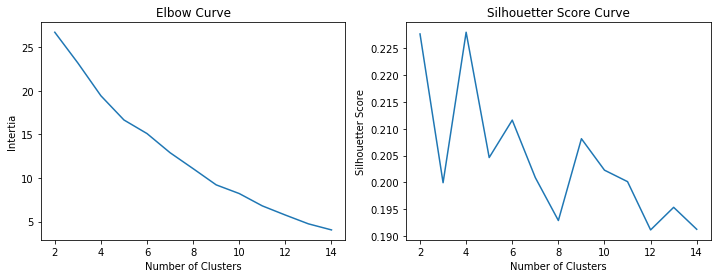

In [108]:
sil = []
inertia = []
for k in range(2,15):
    km = KMeans(n_clusters=k, random_state = 0).fit(cdmx_n) 
    y_pred = km.predict(cdmx_n)
    inertia.append((k, km.inertia_))
    sil.append((k, metrics.silhouette_score(cdmx_n, y_pred)))
fig, ax = plt.subplots(1,2, figsize=(12,4))# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')# Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil), ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score'), ax[1].set_title('Silhouetter Score Curve')

Our silhouette scores are too low (meaning that clusters are too close to one another), and the elbow isn't very defined. Using only altitude and pIndex, we get:

Text(0.5, 1.0, 'Silhouetter Score Curve')

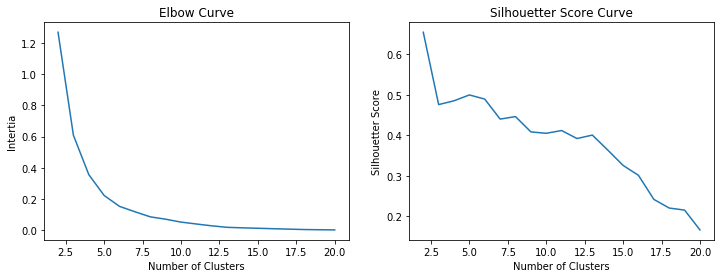

In [109]:
sil = []
inertia = []

subset = ['pIndex', 'Altitude']

for k in range(2,21):
    km = KMeans(n_clusters=k, random_state = 0)
    km.fit(cdmx_n[subset]) 
    y_pred = km.predict(cdmx_n[subset])
    inertia.append((k, km.inertia_))
    sil.append((k, metrics.silhouette_score(cdmx_n[subset], y_pred)))
fig, ax = plt.subplots(1,2, figsize=(12,4))# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve') # Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

This is better! After clustering, we can analyze which variables have an effect on pIndex and which don't. Here, we will use 4 clusters, since the elbow at 2  clusters is too high in its graph; also, 5 clusters leave us with 2 samples in one of the clusters, and that's not enough to determine correlations.

### Analysis: kmeans clustering with 4 clusters and subset 'pIndex', 'Altitude':

In [110]:
x = cdmx_n[subset]
kmeans = KMeans(n_clusters = 4, random_state=0).fit(x)
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 8,  4, 11,  3]))


We have four clusters. One of them has 3 elements, and other has 4. Drawing conclusions from such small sample sizes using correlation analysis will prove difficult and dangerous, but we're going to try anyway. Worst case scenario, our correlations make no sense, and we conclude that this is not the correct method to study this particular case; best case scenario, our correlations make a lot of sense, and we're able to explain them. Either way, results are results. Let's carry on and see our clusters:

In [111]:
cluster_map = deleg.copy()
cluster_cdmx_n = x.copy()

#Add clusters to cluster_map, to cluster_cdmx, and cluster_cdmx_n
if not ('Cluster' in cluster_map.columns):
    cluster_map.insert(0, 'Cluster', kmeans.labels_)
if not ('Cluster' in cluster_cdmx_n.columns):
    cluster_cdmx_n.insert(0, 'Cluster', kmeans.labels_)

cluster_map.head()

,Cluster,Latitude,Longitude,Altitude
AJM,3,19.272100,-99.207658,2619
ATI,1,19.576963,-99.254133,2341
BJU,0,19.371612,-99.158969,2250
CCA,1,19.326200,-99.176100,2280
CHO,2,19.266948,-98.886088,2253


In [112]:
# set color scheme for the clusters
colors_array = ['#ff3300', '#00cc00', 'orange', '#3366ff']

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_map['Latitude'], cluster_map['Longitude'], cluster_map.index, cluster_map['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= colors_array[cluster],
        fill=True,
        fill_color= colors_array[cluster],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

Beautiful. 

<hr>
<h1 align='center'> 5. Cluster examination <h1>
<hr>

We shall now examine our clusters, first visually, and then statistically.

In [113]:
clusters = len(np.unique(kmeans.labels_))
c = np.zeros(clusters, dtype = object) # define array of clusters

for i in range(clusters):
    c[i] = cdmx_n.loc[cluster_cdmx_n['Cluster'] == i, :]

In [157]:
pd.set_option('display.max_columns', None)
global_columns = cdmx_n.columns

In [173]:
def color_map(df, row_labels, col_labels):
    df = df.T
    fig, ax = plt.subplots()
    im = ax.pcolor(df, cmap='RdBu')

    #move ticks and labels to the center
    ax.set_xticks(np.arange(df.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(df.shape[0]) + 0.5, minor=False)

    #insert labels
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(col_labels, minor=False)

    #rotate label if too long
    plt.xticks(rotation=90)

    fig.set_size_inches(7, 5.5)
    fig.colorbar(im)
    plt.show()

In [202]:
#This function generates a correlation matrix. It also multiplies 
#the correlation coefficients by a factor of their respective
#p values. This generates a weighted correlation matrix.

def correlation_matrix_dataframe(df, switch):
    length = len(df.columns)
    cmatrix = np.zeros((length, length))
    
    for i, row in enumerate(df.columns):
        correlations = pearson_correlations(df, row)
        for j in range(i + 1, len(correlations)):
            coefficient = correlations[j, 1]
            p_value = correlations[j, 2]
            
            if (p_value > 0.05) & (switch):
                p_factor = 1./(10 + p_value - 0.05)
            else:
                p_factor = 1.
            
            cmatrix[i, j] = coefficient * p_factor
            cmatrix[j, i] = coefficient * p_factor

    np.fill_diagonal(cmatrix, 1.0)
    
    return cmatrix

### Cluster 0 

In [178]:
c[0]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
BJU,0.847470,0.256198,0.040641,0.113862,0.044154,0.496257,0.994511,0.165441,1.000000,0.700000,0.0,0.6,1.0,0.181818,0.0,0.0,0.666667,0.0,0.866667,1.000,0.0,0.266667,0.0
CUT,0.706593,0.351886,0.021723,0.106789,0.025036,0.379847,0.979027,0.189338,0.069767,0.083333,0.0,0.2,1.0,0.000000,1.0,0.0,0.333333,0.0,0.000000,0.375,0.5,1.000000,0.0
LPR,0.741839,0.440067,0.028166,0.109363,0.011614,0.337304,0.958139,0.261029,0.209302,0.016667,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.0,0.133333,0.250,0.0,0.000000,0.0
MER,0.622147,0.290442,0.042524,0.107401,0.023314,0.385396,0.966489,0.156250,0.581395,0.666667,0.0,0.0,0.0,1.000000,1.0,0.0,0.500000,0.5,0.266667,0.125,0.5,0.066667,0.0
SAG,0.645533,0.295999,0.028343,0.093548,0.012488,0.429552,0.969134,0.148897,0.139535,0.316667,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.266667,0.000,0.0,0.000000,0.0
TLA,0.616621,0.317312,0.038944,0.090505,0.036439,0.369252,0.959923,0.277574,0.418605,1.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.166667,0.0,0.266667,0.250,0.5,0.000000,0.0
VIF,0.607153,0.227209,0.022628,0.089884,0.034898,0.458350,0.973940,0.150735,0.069767,0.233333,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.066667,0.0
XAL,1.000000,0.370503,0.040105,0.081705,0.021105,0.520247,1.000000,0.000000,0.162791,0.083333,0.0,0.0,0.0,0.090909,0.0,0.0,0.500000,0.0,0.133333,0.000,0.0,0.000000,1.0


These stations report the highest pollution. Understandably, the industrial category has a very strong, positive influence on pollution here, as the only station with a factory nearby has the highest pIndex out of all the stations in the dataset.

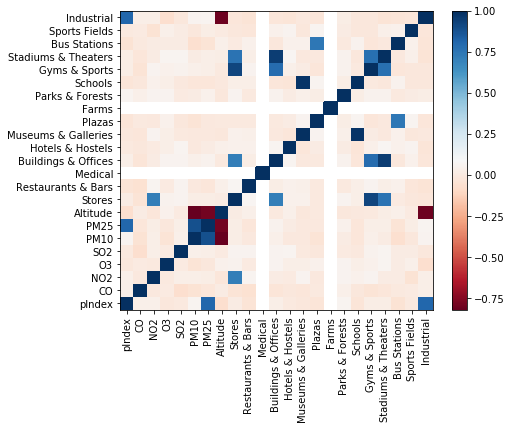

In [203]:
color_map(correlation_matrix_dataframe(c[0], True), c[0].columns, global_columns)

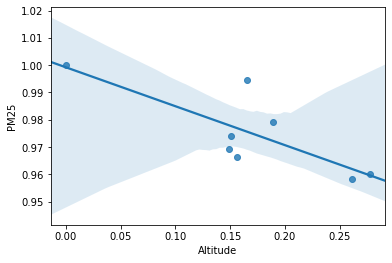

In [247]:
y = 'PM25'
x = 'Altitude'
sns.regplot(x = x, y = y, data=c[0])

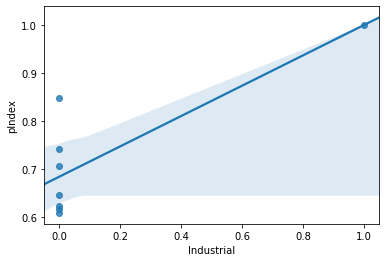

In [224]:
x = 'Industrial'
y = 'pIndex'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

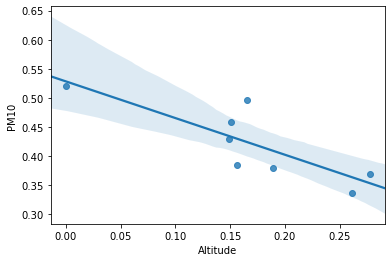

In [226]:
x = 'Altitude'
y = 'PM10'
sns.regplot(x = x, y = y, data=c[0][[x, y]])

### Cluster 1

In [177]:
c[1]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
ATI,0.206851,0.208255,0.024514,0.097785,0.024297,0.314077,0.906926,0.332721,0.000000,0.150000,0.0,0.2,0.0,0.000000,0.0,0.0,0.333333,0.0,0.266667,0.000,0.0,0.133333,0.0
CCA,0.214846,0.211194,0.026990,0.121028,0.011395,0.292734,0.917127,0.220588,0.093023,0.766667,0.0,0.0,0.0,0.181818,1.0,0.0,0.500000,1.0,0.600000,0.875,1.0,0.066667,0.0
MGH,0.220160,0.266887,0.034691,0.099863,0.020461,0.245423,0.916211,0.378676,0.255814,0.866667,1.0,0.0,0.0,1.000000,1.0,0.0,1.000000,0.0,0.533333,0.125,0.0,0.000000,0.0
PED,0.061857,0.173215,0.023902,0.152341,0.010437,0.235708,0.896560,0.305147,0.604651,0.433333,0.0,0.2,0.0,0.090909,1.0,1.0,0.333333,0.0,0.733333,0.000,0.0,0.066667,0.0


In [151]:
print_correlations(pearson_correlations(c[1], 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
                  CO --> +0.76 |  strong  | p value = 0.2430
                 NO2 --> +0.54 | moderate | p value = 0.4568
                  O3 --> -0.90 |  strong  | p value = 0.0981
                 SO2 --> +0.58 | moderate | p value = 0.4164
                PM10 --> +0.59 | moderate | p value = 0.4090
                PM25 --> +0.91 |  strong  | p value = 0.0944
              Stores --> -0.89 |  strong  | p value = 0.1121
  Restaurants & Bars --> +0.31 |   weak   | p value = 0.6874
             Medical --> +0.39 |   weak   | p value = 0.6132
 Buildings & Offices --> -0.63 | moderate | p value = 0.3704
 Museums & Galleries --> +0.39 |   weak   | p value = 0.6114
               Farms --> -1.00 |  strong  | p value = 0.0026
     Parks & Forests --> +0.50 |   weak   | p value = 0.5015
             Schools --> +0.34 |   weak   | p value = 0.6597
       Gyms & Sports --> -0.63 | moderate | p value = 0.3659
 Stadiums & Theaters -->

This cluster represents the slightly polluted areas. This is an understatement, however: let's not lose sight of PM25, which is high accross every cluster, well into the "very dangerous" IMECA level. Correlations between O3 and pIndex, and PM25 and pIndex are as strong as each other in oposite directions, and their p values are quite similar. Even if our p values are too large to believe this correlations, this phenomenon is worth investigating further. 

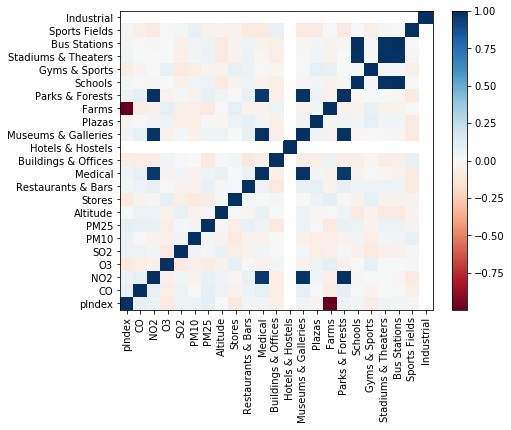

In [204]:
color_map(correlation_matrix_dataframe(c[1], True), c[1].columns, global_columns)

### Cluster 2 

In [176]:
c[2]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
CHO,0.366518,0.260306,0.020351,0.096488,0.000000,0.333582,0.957288,0.170956,0.023256,0.266667,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.200000,0.000,0.0,0.000000,0.0
FAC,0.430544,0.299086,0.032952,0.119550,0.026691,0.269352,0.957341,0.255515,0.186047,0.716667,0.0,0.0,0.0,0.000000,1.0,0.0,0.666667,0.0,0.333333,0.750,0.0,0.066667,0.0
GAM,0.393242,0.171998,0.030883,0.126453,0.002680,0.378658,0.972767,0.123162,0.534884,0.550000,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.600000,0.125,0.5,0.000000,0.0
HGM,0.439562,0.254764,0.037537,0.113954,0.021208,0.315251,0.967460,0.136029,0.627907,0.783333,0.0,0.0,0.0,0.272727,1.0,0.0,0.000000,0.5,0.266667,0.500,0.0,0.000000,0.0
IZT,0.486104,0.289204,0.036225,0.108617,0.015849,0.325170,0.961974,0.143382,0.441860,0.950000,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.266667,0.125,0.0,0.066667,0.0
LLA,0.469941,0.285730,0.030699,0.098515,0.021647,0.333786,0.957334,0.128676,0.488372,0.133333,0.0,0.4,0.0,0.090909,0.0,0.0,0.000000,0.0,0.133333,0.125,0.0,0.066667,0.0
NEZ,0.568160,0.292895,0.028917,0.119268,0.018692,0.345143,0.979488,0.137868,0.209302,0.383333,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.400000,0.000,0.0,0.000000,0.0
TAH,0.471490,0.212784,0.015414,0.138732,0.002397,0.388521,0.970757,0.251838,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.500000,0.0,0.533333,0.250,0.0,0.133333,0.0
TLI,0.391678,0.293454,0.032427,0.118381,0.048196,0.261401,0.928677,0.281250,0.162791,0.133333,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.066667,0.250,0.0,0.000000,0.5
UAX,0.423437,0.236550,0.022073,0.110762,0.006811,0.365995,0.958677,0.158088,0.558140,0.616667,0.0,0.6,0.0,0.000000,0.0,1.0,0.833333,0.0,0.466667,0.125,0.0,0.000000,0.0


In [215]:
print_correlations(pearson_correlations(c[2], 'CO'))

              pIndex --> +0.35 |   weak   | p value = 0.2986
                  CO --> +1.00 |  strong  | p value = 0.0000
                 NO2 --> +0.42 |   weak   | p value = 0.2030
                  O3 --> -0.47 |   weak   | p value = 0.1487
                 SO2 --> +0.66 | moderate | p value = 0.0270
                PM10 --> -0.74 |  strong  | p value = 0.0099
                PM25 --> -0.40 |   weak   | p value = 0.2285
       Gyms & Sports --> -0.71 |  strong  | p value = 0.0146
        Bus Stations --> -0.74 |  strong  | p value = 0.0095


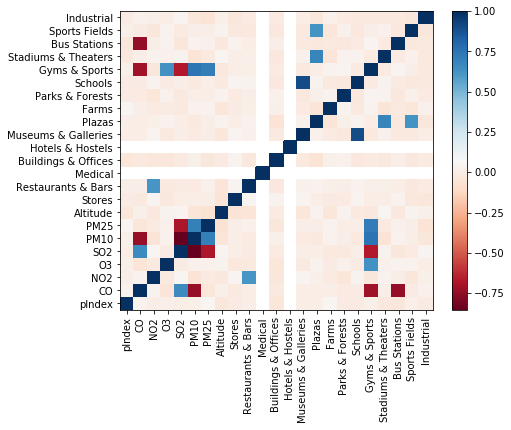

In [205]:
color_map(correlation_matrix_dataframe(c[2], True), c[2].columns, global_columns)

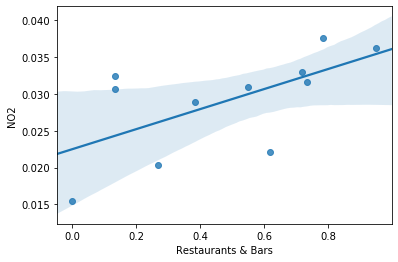

In [220]:
y = 'NO2'
x = 'Restaurants & Bars'
sns.regplot(x = x, y = y, data=c[2][[x, y]])

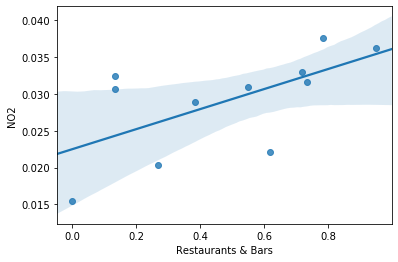

In [220]:
y = 'NO2'
x = 'Restaurants & Bars'
sns.regplot(x = x, y = y, data=c[2][[x, y]])

### Cluster 3

In [175]:
c[3]

,pIndex,CO,NO2,O3,SO2,PM10,PM25,Altitude,Stores,Restaurants & Bars,Medical,Buildings & Offices,Hotels & Hostels,Museums & Galleries,Plazas,Farms,Parks & Forests,Schools,Gyms & Sports,Stadiums & Theaters,Bus Stations,Sports Fields,Industrial
AJM,0.063152,0.160576,0.014453,0.162434,0.017040,0.245542,0.892866,0.843750,0.046512,0.250000,0.0,0.2,0.0,0.0,0.0,0.0,0.166667,0.0,0.266667,0.000,0.0,0.000000,0.0
CUA,0.303390,0.294866,0.023970,0.109620,0.012078,0.224163,0.966879,1.000000,0.465116,0.433333,0.0,0.4,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000,0.0,0.200000,0.0
SFE,0.000000,0.153873,0.025254,0.122352,0.007593,0.246152,0.901235,0.806985,0.372093,0.600000,0.0,1.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.666667,0.125,0.5,0.066667,0.0


In [167]:
print_correlations(pearson_correlations(c[3], 'pIndex'))

              pIndex --> +1.00 |  strong  | p value = 0.0000
                  CO --> +0.99 |  strong  | p value = 0.0996
                  O3 --> -0.53 | moderate | p value = 0.6447
                PM10 --> -0.98 |  strong  | p value = 0.1109
                PM25 --> +0.95 |  strong  | p value = 0.1922
            Altitude --> +1.00 |  strong  | p value = 0.0116
              Stores --> +0.51 | moderate | p value = 0.6573
 Buildings & Offices --> -0.46 |   weak   | p value = 0.6947
     Parks & Forests --> -0.98 |  strong  | p value = 0.1264
       Gyms & Sports --> +0.71 |  strong  | p value = 0.4931
 Stadiums & Theaters --> -0.66 | moderate | p value = 0.5403
        Bus Stations --> -0.66 | moderate | p value = 0.5403
       Sports Fields --> +0.86 |  strong  | p value = 0.3387


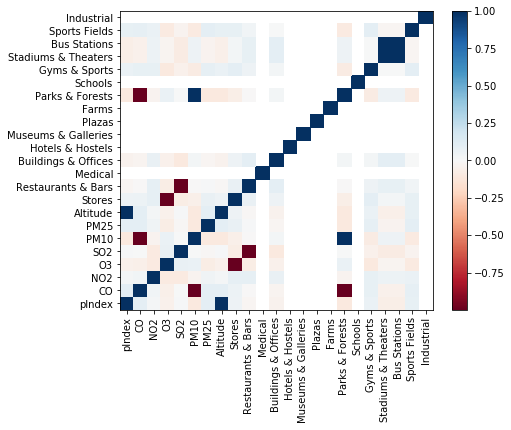

In [207]:
color_map(correlation_matrix_dataframe(c[3], True), c[3].columns, global_columns)

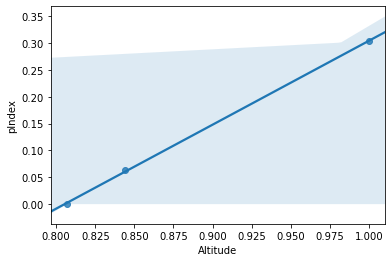

In [211]:
sns.regplot(x='Altitude', y='pIndex', data=c[3][['Altitude', 'pIndex']])